In [29]:
from astropy.table import Table
import numpy as np
from astropy.io import fits
from scipy.interpolate import interp1d

from astropy.convolution import convolve

from matplotlib import pyplot as plt

import urllib # To download COS' LSF files within python

Each COS observation is taken with a specific **grating** and a specific **central wavelength setting** (**cenwave**). Each such configuration (grating and cenwave) and thus each COS dataset has a set of corresponding Line Spread Functions (LSFs). 

#### What is an LSF?
A Line Spread Function (LSF) is a model of a spectrograph's response to a monochromatic light source: it explains how an infinitely thin spectral line (a [delta function](https://en.wikipedia.org/wiki/Dirac_delta_function)) input into the spectrograph would be output at the focal plane. A spectrum with infinite sprectral resolution convolved with the COS LSF will reproduce the COS spectral line profiles:

$$True\ Input\ Spectrum \ast COS\ LSF = True\ Output\ Spectrum$$

Of course, we don't have access to a "true", infinite resolution input spectrum, nor can we know the infinite resolution LSF. The best we can do is use a model spectrum, or a spectrum from a higher resolution spectrograph (STIS often works well) and convolve it with a kernel of our LSF model. Convolving these yields our model output spectrum:

$$Model\ Input\ Spectrum \ast COS\ LSF\ Model = Model\ Output\ Spectrum$$

***Note*** *that there is a corresponding spread function in the cross-dispersion direction, known as the cross-dispersion spread function (CDSF). These functions are also modelled by the COS team and hosted on their website listed below. Working with the CDSFs is out of the scope of this notebook.*

#### How does COS handle the LSF?

The COS LSFs are generated using an optical model of the spectrograph in the program [Code V](https://www.synopsys.com/optical-solutions/codev.html), and are then validated using real spectral data obtained with the instrument. The LSF kernels are sampled at regular intervals over the wavelength range of each COS configuration. Each of these wavelengths thus corresponds to an LSF kernel. The kernel size (in [COS "pixels"](https://hst-docs.stsci.edu/cosihb/glossary)) of each LSF varies for the near ultraviolet (NUV) and far ultraviolet (FUV) modes, as does the sample rate (how many Angstroms between sampled kernels). These values are shown below:

### Table 1.1:
<h3><center>Line Spread Function (LSF) kernel parameters for the COS instrument</center><\h3>
<br><\br>


||LSF kernels sampled every... |Kernel size... |
|-|-|-|
|**COS/NUV**|100 Å|321 *pixels*|
|**COS/FUV**|5 Å|101 *pixels*|


#### How are the LSF files structured?

In short, the LSF files are structured as a list of LSF profile kernels. It begins with a space-separated list of central sample wavelengths are the input monochromatic lines used by Code V. These are not to be confused with COS central wavelength settings, or cenwaves. To avoid confusing the two concepts, we'll call the central wavelengths of the LSF kernels the **LSF wavelengths**.


#### Which LSF files will you need?

This depends on your data's parameters, specifically those listed in Table 1.2.

|**Parameter**|**Corresponding Header Keyword**|**Example used in this notebook**|
|-|-|-|
|Wavelength range|*DETECTOR*|FUV|
|COS lifetime position|*LIFE_ADJ*|3|
|Grating|*OPT_ELEM*|G130M|
|Central wavelength setting|*CENWAVE*|1291|

If your data was taken in COS' NUV configuration, there's only one NUV LSF file which contains all the LSF profiles for the entire NUV. Things are a bit more complicated for FUV data, where you will need to choose an LSF file based on the [COS Lifetime position](https://hst-docs.stsci.edu/cosdhb/appendix-a-cos-lifetime-positions/a-1-cos-lifetime-positions), [grating](https://hst-docs.stsci.edu/cosihb/chapter-13-spectroscopic-reference-material/13-3-gratings), and [central wavelength setting](https://hst-docs.stsci.edu/cosihb/chapter-5-spectroscopy-with-cos/5-5-spanning-the-gap-with-multiple-cenwave-settings) used to capture your data.

You can find all of these in your data's primary fits header. You can do this in DS9 or other software, but we'll briefly do this programmatically below:

In [80]:
fuvFile = './data/lcn502010_x1dsum.fits' # Give the program the path to your data

fuvHeader0 = fits.getheader(fuvFile, ext = 0) # Grab the primary header
print(f"For the file {fuvFile}, the relevant parameters are: ")
param_dict = {} # Make a dict to store what you find here

for hdrKeyword in ['DETECTOR', 'OPT_ELEM', 'LIFE_ADJ', 'CENWAVE']: # print out the relevant values
    print(f"{hdrKeyword} = {fuvHeader0[hdrKeyword]}") # Print the key/value pairs
    param_dict[hdrKeyword] = fuvHeader0[hdrKeyword] # Save the key/value pairs to the dictionary

For the file ./data/lcn502010_x1dsum.fits, the relevant parameters are: 
DETECTOR = FUV
OPT_ELEM = G130M
LIFE_ADJ = 3
CENWAVE = 1291


##### Now that you know *which* LSF files you need, we'll go gather them from the COS team's website:

#### Where can you find the LSF files?
The COS team maintains up-to-date LSF files on the [COS Spectral Resolution page](https://www.stsci.edu/hst/instrumentation/cos/performance/spectral-resolution). Opening up this link leads to a page like that shown in Fig. 1.1, where the LSF files are discussed in detail. The bottom part of this page has links to all the relavent files. The links at the top of the page will take you to the relevant section. In Fig. 1.1, we have circled in black the link to the section pertaining to our data: FUV at the Lifetime Position: 3.

### Fig 1.1
<center><img src=./figures/LSFHomepage.png width ="900" title="COS Spectral Resolution Site"> </center>

Clicking on the circled link takes us to the table of hyperlinks to all the files perataining to data taken with the FUV, Lifetime Postition 3 configutation, shown in Fig. 1.2:

### Fig 1.2
<center><img src=./figures/LSFHomepage2.png width ="900" title="COS Spectral Resolution Site - Lifetime Position 3"> </center>

Circled in solid red is the button to download the LSF file we need for our data with CENWAVE = 1291. Circled in dashed black is the corresponding CDSF.

You can click on the solid red circled button to download the LSF file and move it to this current working directory **or** right-click and select "Download Linked File As..." and download directly to this directory.
* *This step may look somewhat different depending on your browser*
* *If you're unsure of the current working directory, un-comment the `!pwd` statement in the next cell, and run the cell.*

In [27]:
# !pwd

These files can also be downloaded programattically from with python, with the function we definte below:

In [97]:
def fetch_LSF_file(det, grating, lpPos, cenwave):
    COS_site_rootname = "https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/cos/"\
    "performance/spectral-resolution/_documents/" # Link to where all the files live
    if det == "NUV":
        LSF_file_name = "nuv_model_lsf.dat"
    elif det == "FUV":
        LSF_file_name = f"aa_LSFTable_{grating}_{cenwave}_LP{lpPos}_cn.dat"
        
    LSF_file_webpath = COS_site_rootname + LSF_file_name # Where to find file online
    urllib.request.urlretrieve(LSF_file_webpath, './'+LSF_file_name) # Where to save file to locally
    print(f"Downloaded to ./{LSF_file_name}")

We'll run this function with the parameters we saved earlier to gather the proper LSF file:

In [98]:
fetch_LSF_file(*list(param_dict.values())) # This works because of the order in which we added to the dict

Downloaded to ./aa_LSFTable_G130M_1291_LP3_cn.dat


#### Below, we create a simple function to read in an LSF file as an astropy table:

In [103]:
def read_lsf(filename):
    # The first column is a list of the wavelengths corresponding to the line profile, so we set our header accordingly
    lsf = Table.read(filename, format='ascii', header_start=0)

    # middle pixel of the lsf is considered zero ; center is relative zero
    pix = np.arange(len(lsf)) - len(lsf) // 2 # integer division to have whole pixels I assume

    # the column names returned as integers.
    w = np.array([int(k) for k in lsf.keys()])

    return lsf, pix, w

In [104]:
lsf, pix, w = read_lsf(LSF_file_name)

In [106]:
lsf

1134,1139,1144,1149,1154,1159,1164,1169,1174,1179,1184,1189,1194,1199,1204,1209,1214,1219,1224,1229,1234,1239,1244,1249,1254,1259,1264,1269,1274,1295,1300,1305,1310,1315,1320,1325,1330,1335,1340,1345,1350,1355,1360,1365,1370,1375,1380,1385,1390,1395,1400,1405,1410,1415,1420,1425,1430
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
4.885797114010963e-06,4.787755984607906e-06,4.713489842513227e-06,4.735199692705489e-06,4.7784485923017495e-06,4.879469918145371e-06,4.927128206666398e-06,5.090850392818559e-06,5.15178364251108e-06,5.409926268187645e-06,5.432407030561909e-06,5.473950213727599e-06,5.739104054931698e-06,5.817675997701938e-06,5.791799686870484e-06,5.813510640407913e-06,5.919006684936984e-06,6.069346625282098e-06,6.113738542903514e-06,6.077017393236751e-06,6.142944187065456e-06,6.077323510220381e-06,6.0315095342750314e-06,6.03393886088309e-06,5.908580035451082e-06,5.85115162099207e-06,5.826107451379306e-06,5.627519099393904e-06,5.658009437485419e-06,5.630844763743024e-06,5.672274118192269e-06,5.5822822581877175e-06,5.65847338853098e-06,5.972442833036891e-06,5.9201130527291825e-06,5.8917168914499645e-06,5.899479348496698e-06,6.203180774508649e-06,6.190678724687938e-06,6.056401802240287e-06,6.117488490547525e-06,6.356429476377104e-06,6.258437799147606e-06,6.24689194497589e-06,6.3587517420493495e-06,6.44245101671056e-06,6.4023120118422186e-06,6.315380882946153e-06,6.292531563694942e-06,6.427649865424248e-06,6.3680743675560694e-06,6.102822585011076e-06,6.19616102714398e-06,6.149117419674539e-06,6.2404201300884755e-06,5.90617663436457e-06,6.0269090865381226e-06
4.916023102906068e-06,4.873309105308387e-06,4.752957668230419e-06,4.749528365900715e-06,4.8460096205578055e-06,4.940918732209036e-06,4.924616030740943e-06,5.0920156150170196e-06,5.190451290942636e-06,5.370707691511361e-06,5.391754072345527e-06,5.466202674362947e-06,5.759790177456652e-06,5.864327841634872e-06,5.821370859398367e-06,5.8024223882308275e-06,5.959112702425401e-06,6.1062246586809784e-06,6.241673313962351e-06,6.143056282395135e-06,6.2167951109733965e-06,6.219012593999937e-06,6.0685111046980535e-06,6.024917526215172e-06,5.88174668332283e-06,5.764819759525213e-06,5.791689165650563e-06,5.655756352300768e-06,5.6905473188837e-06,5.543981679326107e-06,5.606233215774545e-06,5.531819872116674e-06,5.697234601221519e-06,5.959282879522049e-06,5.927344703554368e-06,5.966621392397594e-06,5.906735236340958e-06,6.247237453019061e-06,6.260300712058006e-06,6.1348341677476794e-06,6.2100181157419064e-06,6.52021998238568e-06,6.396758673598252e-06,6.3567530142809344e-06,6.4606718561567056e-06,6.609477404017343e-06,6.545610897085236e-06,6.50313517725783e-06,6.47205889752838e-06,6.570560291074339e-06,6.489391173617323e-06,6.22377516701644e-06,6.316233894482927e-06,6.311100420763779e-06,6.317891304633927e-06,6.01493047970482e-06,6.154112746183588e-06
4.941950149310319e-06,4.954122351536572e-06,4.829737664959035e-06,4.819638005845053e-06,4.959435869169078e-06,5.054721131875638e-06,4.972573864692993e-06,5.131879878689711e-06,5.247968104496962e-06,5.360724227358167e-06,5.394568121575074e-06,5.462948604381005e-06,5.765959310669059e-06,5.884440549970831e-06,5.81101418729848e-06,5.773410154735602e-06,5.9433750983161066e-06,6.077752055780653e-06,6.257886684341022e-06,6.173387561900703e-06,6.2598977749148165e-06,6.306698713339108e-06,6.093747341023172e-06,6.0382179841287355e-06,5.880336937582449e-06,5.727328513251527e-06,5.7898091366474e-06,5.706510506542616e-06,5.749247354531632e-06,5.529025233363027e-06,5.575271690103601e-06,5.543759283571852e-06,5.7546633195593125e-06,5.949337473330958e-0

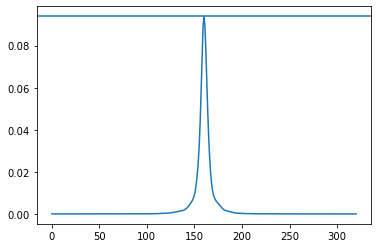

In [102]:
plt.plot(lsf['1134'])
plt.axhline(lsf['1134'][int((len(lsf['1134']))/2)])

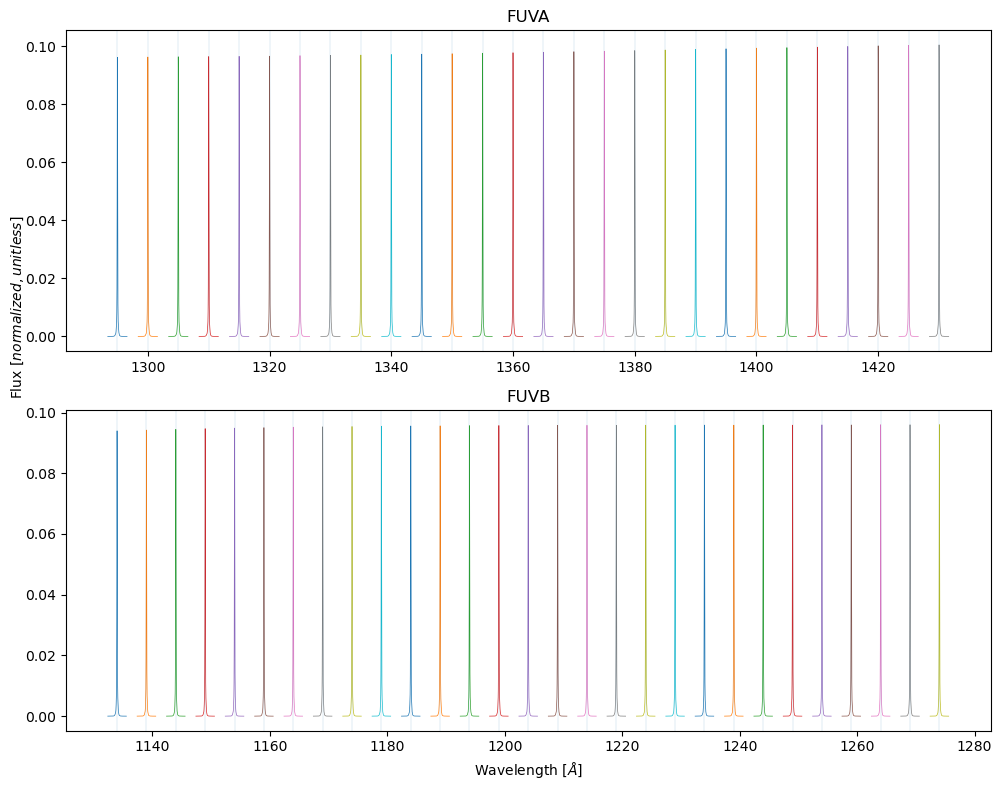

In [91]:
fig, (ax0,ax1) = plt.subplots(2,1, figsize = (10,8), dpi = 100)

for i, col in enumerate(lsf.colnames):
    line_wvln = float(col)
    contents = lsf[col].data
    if line_wvln < 1291:
        wing_size = (len(contents) - 1)/2
        xrange = (0.0099*(np.arange(-wing_size, wing_size + 1)) + line_wvln)
        ax1.plot(xrange , contents, linewidth = 0.5)
        ax1.axvline(line_wvln, linewidth = 0.1)
    elif line_wvln > 1291:
        wing_size = (len(contents) - 1)/2
        xrange = (0.0099*(np.arange(-wing_size, wing_size + 1)) + line_wvln)
        ax0.plot(xrange , contents, linewidth = 0.5)
        ax0.axvline(line_wvln, linewidth = 0.1)

ax1.set_title("FUVB")
ax0.set_title("FUVA")
ax1.set_xlabel("Wavelength [$\AA$]")
fig.text(s = "Flux [$normalized,unitless$]", x = 0, y = 0.5, rotation = 'vertical' )

plt.tight_layout()

|c||||
|-|-|-|-|
|||||
|||||